In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

from tqdm import tqdm

import torchtext
import torch
from torch import nn

from transformers import DistilBertForSequenceClassification, BertForSequenceClassification, DistilBertTokenizer, AdamW

In [3]:
# Set params
device = 'cuda'
pretrained_weights = 'distilbert-base-uncased' # specify type of BERT we want

In [42]:
# load BERT tokenizer and classifier
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_weights)
bert = DistilBertForSequenceClassification.from_pretrained(pretrained_weights)
bert = bert.to(device)

# Load IMDb

In [5]:
# set up fields
TEXT = torchtext.data.Field(
    lower=True, 
    fix_length = 256,
    batch_first=True, 
    truncate_first=True,
    tokenize = tokenizer.tokenize, 
    pad_token=tokenizer.pad_token,
    unk_token=tokenizer.unk_token,
    init_token=tokenizer.cls_token,
    eos_token=tokenizer.sep_token,
)
LABEL = torchtext.data.Field(sequential=False)

In [39]:
# make splits for adversarial set
train_adv, test_adv = torchtext.datasets.IMDB(
    '../data/adversarial_imdb_10k/train',
    TEXT,
    LABEL,
).split(split_ratio=.8, stratified=True)

In [ ]:
# make splits for original set
train, test = torchtext.datasets.IMDB.splits(TEXT, LABEL)

In [40]:
# build the vocabulary
TEXT.build_vocab(train_adv)
LABEL.build_vocab(train_adv)

itos = [token for token in tokenizer.vocab]
stoi = {token: index for index, token in enumerate(tokenizer.vocab)}
stoi['[unk]'] = stoi['[UNK]']

TEXT.vocab.itos = itos
TEXT.vocab.stoi = stoi

In [10]:
# with open('imdb_train', 'w') as f:
#     for ex in train:
#         text = tokenizer.decode(tokenizer.convert_tokens_to_ids(ex.text))
#         text = text.replace('< br / >', '<br />')
#         label = ['neg', 'pos'].index(ex.label)
#         f.write(str(label) + ' ' + text + '\n')

In [41]:
# make iterator for splits
train_adv_iter, test_adv_iter = torchtext.data.BucketIterator.splits(
    (train_adv, test_adv), batch_size=16, device=device)

In [ ]:
# make iterator for splits
train_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train, test), batch_size=16, device=device)

# Train BERT

In [9]:
def undersample_neg(text, label):
    neg_locs = torch.where(label == 0)[0]
    pos_locs = torch.where(label == 1)[0]
    if len(pos_locs) == 0:
        return text, label
    neg_loc_sample = neg_locs[torch.randint(high=len(neg_locs), size=(len(pos_locs),))]
    sample_loc = torch.cat([pos_locs, neg_loc_sample])
#     print(pos_locs, neg_loc_sample, sample_loc)
    return text[sample_loc], label[sample_loc]

In [ ]:
# lock all by the last k layers for training
# num_unlocked = 5
# for param in list(bert.parameters())[:-num_unlocked*2]:
#     param.requires_grad = False
# for param in list(bert.parameters())[-num_unlocked*2:]:
#     param.requires_grad = True
[x.requires_grad for x in bert.parameters()][-10:]

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(bert.parameters(), lr=1e-3)

In [44]:
# keep track of train and validation performance
losses = []
accuracies = []
val_losses = []
val_accuracies = []

In [45]:
verbose_interval = 20
num_epochs = 20

for epoch in range(num_epochs):
    for ibatch, batch in enumerate(train_adv_iter):
        text = batch.text
        label = batch.label - 1
#         text, label = undersample_neg(text, label)
        
        optimizer.zero_grad()
        output = bert(text)[0]
        acc = np.mean((output.argmax(dim=-1) == label).cpu().numpy())
        accuracies.append(acc)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (ibatch + 1) % verbose_interval == 0:
            print(epoch+1, ibatch+1, np.mean(losses[-verbose_interval:]), np.mean(accuracies[-verbose_interval:]), sep='\t')
    
    val_batch_losses = []
    val_batch_accuracies = []
    for batch in list(test_adv_iter):
        text = batch.text
        label = batch.label - 1
        output = bert(text)[0]
        acc = np.mean((output.argmax(dim=-1) == label).cpu().numpy())
        val_batch_accuracies.append(acc)
        loss = criterion(output, label)
        val_batch_losses.append(loss.item())
    val_losses.append(np.mean(val_batch_losses))
    val_accuracies.append(np.mean(val_batch_accuracies))
    
    print(f'val. loss: {val_losses[-1]:0.5f}\t val. acc: {val_accuracies[-1]*100:0.2f}%')

1	20	0.7303301423788071	0.525
1	40	0.7019224733114242	0.490625
1	60	0.709674420952797	0.496875
1	80	0.697924017906189	0.471875
1	100	0.6947230070829391	0.503125
1	120	0.6970780581235886	0.465625
1	140	0.7048288345336914	0.49375
1	160	0.6964115381240845	0.5
1	180	0.695009070634842	0.49375
1	200	0.6925548821687698	0.553125
1	220	0.6964047074317932	0.503125
1	240	0.6929316401481629	0.525
1	260	0.6944901436567307	0.50625
1	280	0.6921051770448685	0.53125
1	300	0.6946153759956359	0.490625
1	320	0.6937148183584213	0.475
1	340	0.6930106937885284	0.5125
1	360	0.6941011488437653	0.459375
1	380	0.6936863452196121	0.4875
val. loss: 0.69316	 val. acc: 49.96%
2	20	0.6931402921676636	0.50625
2	40	0.6939526557922363	0.490625
2	60	0.6933859825134278	0.453125
2	80	0.6933535784482956	0.484375
2	100	0.6933422297239303	0.48125
2	120	0.6936003029346466	0.484375
2	140	0.693405932188034	0.48125
2	160	0.692896056175232	0.528125
2	180	0.693801012635231	0.4875
2	200	0.6935030609369278	0.475
2	220	0.6938733488321

KeyboardInterrupt: 

In [20]:
def evaluate(model, eval_iter):
    scores = []
    for ibatch, batch in enumerate(tqdm(eval_iter)):
        text = batch.text
        label = batch.label - 1

        output = model(text)[0]
        acc = np.mean((output.argmax(dim=-1) == label).cpu().numpy())
        scores.append(acc)
        
    return np.mean(scores)

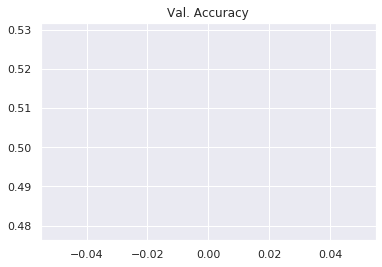

In [27]:
plt.plot(val_accuracies)
plt.title('Val. Accuracy')
plt.show()

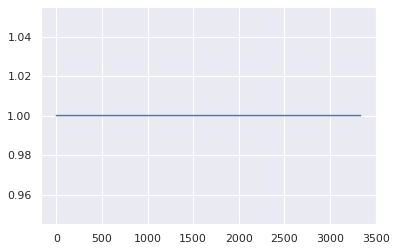

In [18]:
plt.plot(accuracies)

In [21]:
evaluate(bert, test_adv_iter)

100%|██████████| 50/50 [00:06<00:00,  7.33it/s]


1.0

In [22]:
evaluate(bert, list(test_iter)[:50])

100%|██████████| 50/50 [00:06<00:00,  7.36it/s]


0.434375

In [ ]:
evaluate(bert, test_iter)